# 序列模型

## 序列数据：

实际中很多数据都有时序结构

如：电影的评价随时间变化而变化

## 序列模型

$ p(x) = p(x_1)*p(x_2|x_1)*p(x_3|x_2,x_1)*...*p(x_T|x_1,x_2,...,x_{T-1}) $

对条件概率建模：

$ p(x_t|x_1,x_2,...,x_{t-1}) = p(x_t|f(x_1,x_2,...,x_{t-1})) $

# 方案A - markov模型

假设当前数据只和τ个过去数据点有关

$ p(x_t|x_1,x_2,...,x_{t-1}) = p(x_t|x_{t-τ},x_{t-τ+1},...,x_{t-1}) = p(x_t|f(x_{t-τ},x_{t-τ+1},...,x_{t-1})) $

# 方案B - 潜变量模型

引入潜变量$h_t$来表示过去信息$h_t = f(x_1,...,x_{t-1})$

这样$x_t = p(x_t|h_t)$

![](./assets/hidden_state_model.jpg)

理解：用一系列隐状态凝练它之前的所有状态的信息总体

# 序列模型的一个代码模拟

以下向一个正弦函数中加入噪声后，模拟一个序列数据集

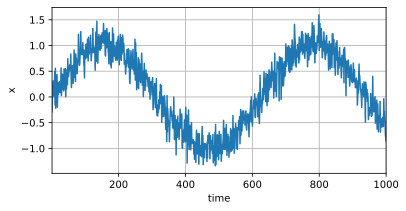

In [2]:
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l

T = 1000  # 总共产生1000个点
time = torch.arange(1, T + 1, dtype=torch.float32)
x = torch.sin(0.01 * time) + torch.normal(0, 0.2, (T,))
d2l.plot(time, [x], 'time', 'x', xlim=[1, 1000], figsize=(6, 3))

提取特征，每个特征向量就是几个连续的函数值$x_i, x_{i+1}, \dots, x_{i+τ-1}$，标签是$x_{i+τ}$

In [3]:
tau = 4
features = torch.zeros((T - tau, tau))
for i in range(tau):
    features[:, i] = x[i:T-tau+i]
labels = x[tau:].reshape((-1, 1))

batch_size, n_train = 16, 600
train_iter = d2l.load_array((features[:n_train], labels[:n_train]), batch_size, is_train=True)

定义模型、损失函数、参数初始化函数

In [4]:
# 初始化网络权重的函数
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)

# 一个简单的多层感知机
def get_net():
    net = nn.Sequential(nn.Linear(4, 10),
                        nn.ReLU(),
                        nn.Linear(10, 1))
    net.apply(init_weights)
    return net

# 平方损失。注意：MSELoss计算平方误差时不带系数1/2
loss = nn.MSELoss(reduction='none')

训练函数

In [5]:
def train(net, train_iter, loss, epochs, lr):
    trainer = torch.optim.Adam(net.parameters(), lr)
    for epoch in range(epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X), y)
            l.sum().backward()
            trainer.step()
        print(f'epoch {epoch + 1}, '
              f'loss: {d2l.evaluate_loss(net, train_iter, loss):f}')

net = get_net()
train(net, train_iter, loss, 5, 0.01)

epoch 1, loss: 0.057263
epoch 2, loss: 0.054090
epoch 3, loss: 0.050689
epoch 4, loss: 0.051653
epoch 5, loss: 0.049863


用训练后的模型预测需了解，画在图上，比较和真实数据差距

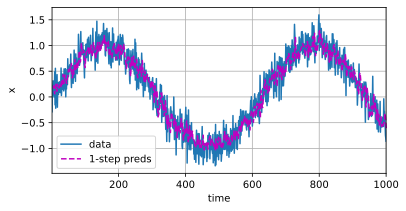

In [6]:
onestep_preds = net(features)
d2l.plot([time, time[tau:]],
         [x.detach().numpy(), onestep_preds.detach().numpy()], 'time',
         'x', legend=['data', '1-step preds'], xlim=[1, 1000],
         figsize=(6, 3))

多步预测：对600(训练数据)之后的数据不通过原始数据进行预测，而是用自己前面推出来的预测结果作为输入，来预测下一个值。

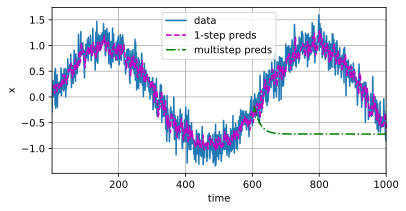

In [7]:
multistep_preds = torch.zeros(T)
multistep_preds[: n_train + tau] = x[: n_train + tau]
for i in range(n_train + tau, T):
    multistep_preds[i] = net(
        multistep_preds[i - tau:i].reshape((1, -1)))

d2l.plot([time, time[tau:], time[n_train + tau:]],
         [x.detach().numpy(), onestep_preds.detach().numpy(),
          multistep_preds[n_train + tau:].detach().numpy()], 'time',
         'x', legend=['data', '1-step preds', 'multistep preds'],
         xlim=[1, 1000], figsize=(6, 3))

可以看出600之后过了几个之后效果很差。

比较预测步数长度的影响：

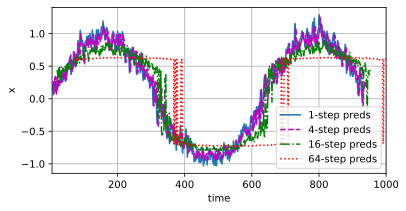

In [8]:
max_steps = 64

features = torch.zeros((T - tau - max_steps + 1, tau + max_steps))
# 列i（i<tau）是来自x的观测，其时间步从（i）到（i+T-tau-max_steps+1）
for i in range(tau):
    features[:, i] = x[i: i + T - tau - max_steps + 1]

# 列i（i>=tau）是来自（i-tau+1）步的预测，其时间步从（i）到（i+T-tau-max_steps+1）
for i in range(tau, tau + max_steps):
    features[:, i] = net(features[:, i - tau:i]).reshape(-1)

steps = (1, 4, 16, 64)
d2l.plot([time[tau + i - 1: T - max_steps + i] for i in steps],
         [features[:, (tau + i - 1)].detach().numpy() for i in steps], 'time', 'x',
         legend=[f'{i}-step preds' for i in steps], xlim=[5, 1000],
         figsize=(6, 3))